# ガウス過程の実装

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import time
from mpl_toolkits.mplot3d import Axes3D 

import numpy as np
from scipy import stats
import scipy as sp
from PIL import Image, ImageDraw

In [2]:
class LinearRegression:
    '''平均と精度が未知の多次元ガウス分布の学習
    '''
    def __init__(self, lam, w_m, w_lam):
        '''事前分布の初期パラメータを設定する
        inputs : lam, float, lam > 0
                      w_m, array(D * 1)
                      w_lam, array(D * D), lam_w > 0
        '''
        self.lam = lam
        self.w_m = np.array(w_m)
        self.w_lam = np.array(w_lam)
        self.w_lam_inv = np.linalg.inv(self.w_lam)
        
        self.D = w_lam.shape[0]
        
    def fit(self, X, Y):
        '''試行X後の事後分布によって事前分布を更新
        inputs : X, array(D * N)
                      Y, array(1 * N)
        return : None
        '''
        tmp = np.zeros((self.D, self.D))
        for i in range(X.shape[1]):
            tmp += np.dot(X[:, i].reshape(self.D, 1), X[:, i].reshape(1, self.D))
        w_lam_old = np.array(self.w_lam)
        self.w_lam += self.lam*tmp
        self.w_lam_inv = np.linalg.inv(self.w_lam)
        tmp = self.lam * np.dot(X, Y.reshape(-1, 1)) + np.dot(w_lam_old, self.w_m.reshape(-1, 1))
        self.w_m = np.dot(self.w_lam_inv, tmp)
        return 
                
    def pred(self, X):
        '''学習したパラメータをつかって新たなデータで回帰
        inputs : X, array(D * N)
        return : array(N * D)
        '''
        return np.dot(self.w_m.reshape(1, -1), X)

    def pred_1sigma(self, X):
        '''学習したパラメータをつかって新たなデータで回帰
        inputs : X, array(D * N)
        return : array(N * D)
        '''
        sigmas = []
        for i in range(X.shape[1]):
            sigmas.append((1/self.lam) + np.dot(np.dot(X[:,i].T, self.w_lam_inv), X[:,i]))
        return np.array(sigmas)

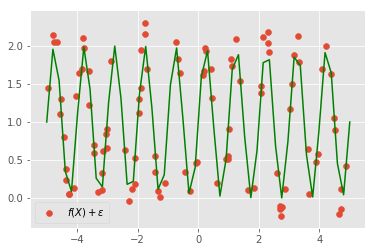

In [3]:
# ターゲットの分布
sigma_y = 0.2

N = 100
np.random.seed(42)
train_X = np.random.uniform(-5, 5, N)
train_y = np.sin(2 * np.pi * train_X) + np.random.normal(0, sigma_y, N) + 1
plt.plot(np.linspace(-5,5), np.sin(2 * np.pi * np.linspace(-5, 5)) + 1, "g")
# plt.scatter(train_X, np.sin(2 * np.pi * train_X)+1, c="b", label=r"$f(X)$")
plt.scatter(train_X, train_y, label=r"$f(X) + \epsilon$")
plt.legend()
plt.show()

## ベイズ線形回帰
事前分布にガウス分布を仮定したガウス線形回帰

before learning


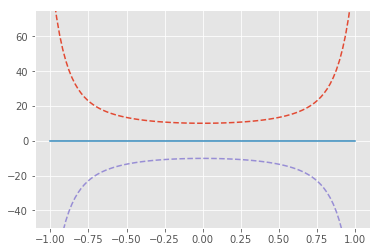

after 100 samples
0.0014748573303222656


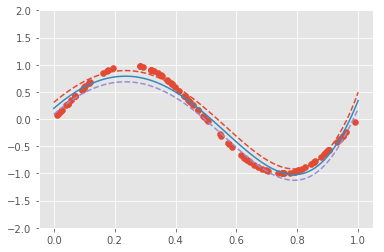

after 200 samples
0.001119375228881836


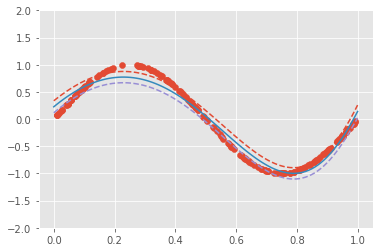

after 300 samples
0.00124359130859375


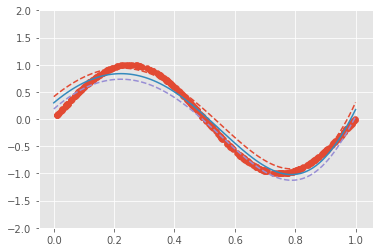

after 400 samples
0.0010294914245605469


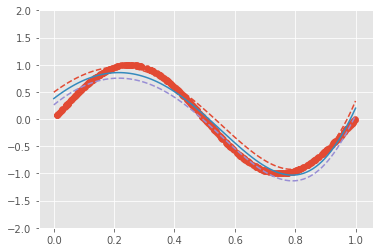

after 500 samples
0.001535177230834961


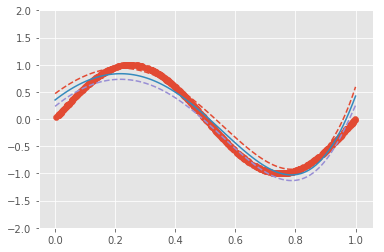

after 600 samples
0.0013239383697509766


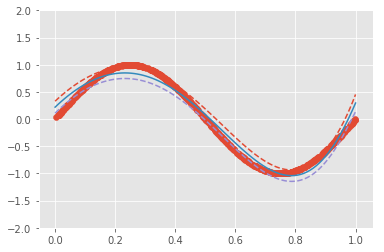

after 700 samples
0.0014188289642333984


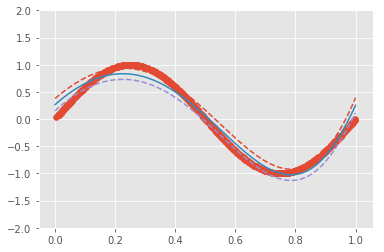

after 800 samples
0.0014503002166748047


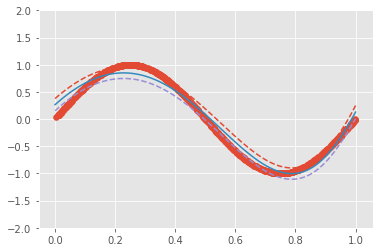

after 900 samples
0.001619100570678711


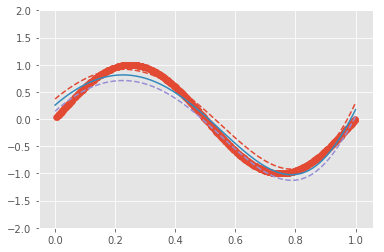

after 1000 samples
0.001203298568725586


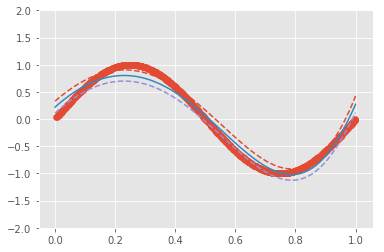

In [5]:
# 初期設定
dim = 10
lam = 10
w_m = np.zeros(dim)
w_sigma = np.eye(dim) * 10
w_lam = np.linalg.inv(w_sigma)

lr = LinearRegression(lam, w_m, w_lam)

# # 学習前
print("before learning")

# 予測分布
X = np.linspace(-1, 1,100) 
data = np.array([X**i for i in range(dim)])
pred = lr.pred(data).reshape(-1)
one_sigma =  lr.pred_1sigma(data).reshape(-1)
plt.plot(X, pred+one_sigma, linestyle="dashed")
plt.plot(X, pred)
plt.plot(X, pred-one_sigma, linestyle="dashed")
plt.ylim(-50, 75)
plt.show()
# show_img(X, sampled, "before learning", IMG_PATH+f"{img_num}.png")


N = 100
max_iter = 10
X_all = np.zeros(2)
Y_all = np.zeros(2)
for i in range(max_iter):
    lr = LinearRegression(lam, w_m, w_lam)
    print(f"after {N*(i+1)} samples")
    # 真のモデルからのデータ
    X = np.random.uniform(0, 1, size=N)
    data = np.array([X**i for i in range(dim)])
    Y = np.sin(2 * np.pi * X)
#     Y =  X**2 + 10*np.sin(X)
    X_all = np.r_[X_all, X]; Y_all = np.r_[Y_all, Y]
    
    # 事後分布の更新
    start = time.time()
    lr.fit(data, Y)
    print(time.time() - start)
#     print(gauss.show_params())
    
    # 予測分布
    X = np.linspace(0,1,100) 
    data = np.array([X**i for i in range(dim)])
    pred = lr.pred(data).reshape(-1)
    one_sigma =  lr.pred_1sigma(data).reshape(-1)
    plt.scatter(X_all[2:], Y_all[2:])
    plt.plot(X, pred+one_sigma, linestyle="dashed")
    plt.plot(X, pred)
    plt.plot(X, pred-one_sigma, linestyle="dashed")
    plt.ylim(-2, 2)
    plt.show()
# ims = []
# for i in range(max_iter+1):
#     ims.append(Image.open(IMG_PATH+f"{i}.png"))
# ims[0].save(IMG_PATH+"out.gif", save_all=True, append_images=ims[1:], duration=60)

## ガウス過程

In [114]:
class GaussianProcess:
    '''ガウス過程
    '''
    def __init__(self, kernel, sigam_y):
        '''事前分布の初期パラメータを設定する
        inputs : kernel, func(x1,x2)
                     sigma_y, float, sigma_y > 0
        '''
        self.kernel = kernel
        self.sigma_y = sigma_y
        
        self.K = np.array([])
        self.K_inv = np.array([])
        self.observed_Y = np.array([])
        self.observed_X = np.array([])
        
    def fit(self, X, Y):
        '''(X, Y)のペアを観測した後のKを更新する
        inputs : X, array(N)
                      Y, array(N)
        return : None
        '''
        X_mesh, X_mesh_ = np.meshgrid(X, X)
        K = np.vectorize(self.kernel)(X_mesh, X_mesh_)
        K += self.sigma_y ** 2 * np.eye(K.shape[0])
        self.K = K
        self.K_inv = sp.linalg.inv(K)
        self.observed_Y = Y
        self.observed_X = X
        return 
                
    def pred(self, X):
        '''学習したパラメメーターを使って予測分布のmu, sigmaを出力
        inputs : X, array(N)
        return : mu, array(N)
                     sigma, array(N)
        '''
        x_mesh, X_mesh = np.meshgrid(X, self.observed_X)
        k_new = np.vectorize(self.kernel)(x_mesh, X_mesh)
        mu =np.dot(np.dot(k_new.T, self.K_inv), self.observed_Y)
        x_mesh, x_mesh = np.meshgrid(X, X)
        sigma = np.vectorize(self.kernel)(x_mesh, x_mesh) - np.dot(np.dot(k_new.T, self.K_inv), k_new)
        sigma = np.sqrt(sigma)
        return mu, np.diag(sigma)

In [227]:
def gaussian_kernel(x, y, sigma = 0.2):
    # RBFカーネル
    return np.exp(- ((x - y) ** 2) / (2 * sigma ** 2))

def euclid_kernel(x, y):
    # ユークリッドカーネル
    return x*y

def poly_kernel(x, y, c=1,d=2):
    # 多項式カーネル
    return np.power(c+x*y, d)

def target(x):
    return np.sin(2 * np.pi * train_X) + np.cos(2 * np.pi * train_X)

# def target(x):
#     return 1/2*x**2 + x

def sample(x, target_func, sigma=0.2):
    # target_funcにノイズを加える
    return target_func(x) + np.random.normal(0, 0.2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


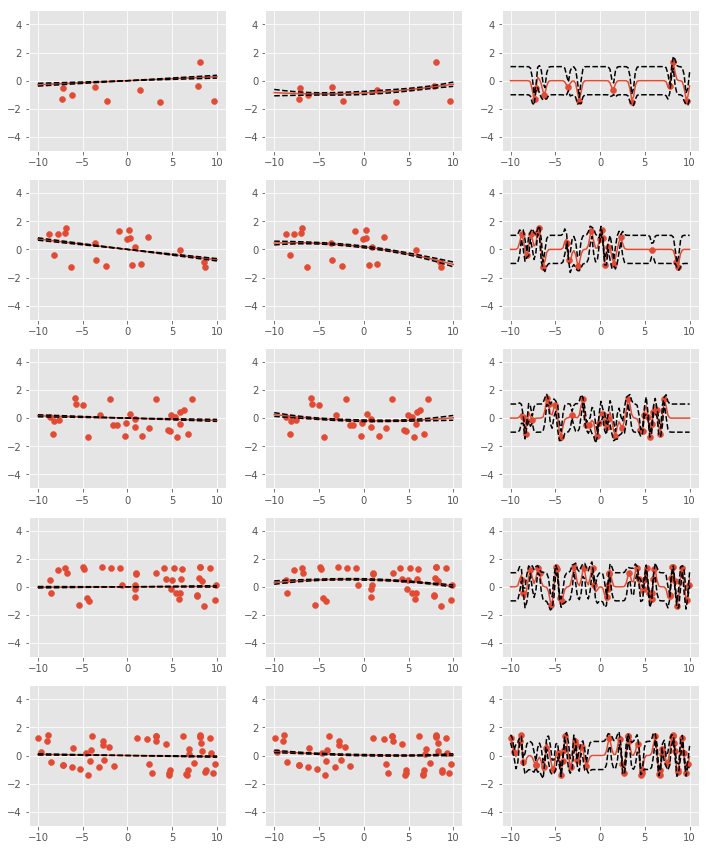

In [230]:
# # 観測変数のスケーリング
# train_y_max = np.max(train_y)
# train_y_min = np.min(train_y)
# max_min = train_y_max - train_y_min
# scaled_train_y = train_y - train_y_min / (max_min)
# gp = GaussianProcess(kernel, sigma_y)
# gp.fit(train_X, scaled_train_y)


max_iter = 5
fig,axes = plt.subplots(nrows=max_iter, ncols=3, figsize=(12, int(max_iter*3)))
for i in range(max_iter):
    # サンプルの生成
    N = 10 * (i+1)
    train_X = np.random.uniform(-10, 10, N)
    train_y = sample(train_X, target)
    
    kernels = [euclid_kernel, poly_kernel, gaussian_kernel]
    for j in range(len(kernels)):
        # 観測変数のスケーリング有り
        gp = GaussianProcess(kernels[j], 0.1)
        gp.fit(train_X, train_y)

        x = np.linspace(-10, 10, 100)
        mu, sigma = gp.pred(x)

        axes[i, j].scatter(train_X, train_y)
        axes[i, j].plot(x, mu)
        axes[i, j].plot(x, mu+sigma, "k--")
        axes[i, j].plot(x, mu-sigma, "k--")
        axes[i, j].set_ylim(-5, 5)

plt.show()